## EDA

### 1.1: Load the Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
from utils import FitData


In [ ]:
import os

# Create data folder if it doesn't exist
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# Dataset URL
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"

zip_file = os.path.join(data_dir, "ml-32m.zip")
extract_folder = os.path.join(data_dir, "ml-32m")

print(f"Starting download of {url}...")

# Download into data/ folder
!wget -q $url -O $zip_file

print("Download complete.")

# Verify download
if os.path.exists(zip_file):
    print(f"Successfully downloaded {zip_file}.")

    # Unzip into data/ml-32m/
    print(f"Unzipping {zip_file}...")
    !unzip -o $zip_file -d $extract_folder

    print(f"Successfully unzipped to '{extract_folder}' folder.")

    # List extracted contents
    print(f"\nContents of {extract_folder}:")
    !ls -l $extract_folder
else:
    print(f"Error: {zip_file} was not downloaded.")


Starting download of https://files.grouplens.org/datasets/movielens/ml-32m.zip...
Download complete.
Successfully downloaded data/ml-32m.zip.
Unzipping data/ml-32m.zip...
Archive:  data/ml-32m.zip
  inflating: data/ml-32m/ml-32m/tags.csv  
  inflating: data/ml-32m/ml-32m/links.csv  
  inflating: data/ml-32m/ml-32m/README.txt  
  inflating: data/ml-32m/ml-32m/checksums.txt  
  inflating: data/ml-32m/ml-32m/ratings.csv  
  inflating: data/ml-32m/ml-32m/movies.csv  
Successfully unzipped to 'data/ml-32m' folder.

Contents of data/ml-32m:
total 9
drwxrwxr-x 2 dolan people 8 Nov 21 15:26 ml-32m


In [ ]:
ratings_path = "data/ml-32m/ml-32m/ratings.csv"
movies_path = "data/ml-32m/ml-32m/movies.csv"

data = FitData(ratings_path, movies_path)
data.load()


### 1.3: Plottings

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import Counter
import csv

# Optional: scipy.sparse for spy visualization if installed
try:
    from scipy import sparse
    SCIPY_SPARSE_AVAILABLE = True
except Exception:
    SCIPY_SPARSE_AVAILABLE = False

# ---------------------------
# Extract arrays directly from FitData
# ---------------------------
def extract_arrays_from_fitdata(fd):
    """
    Extract flat arrays of user IDs, movie IDs, and scores from a FitData instance.
    Returns:
        users_arr, movies_arr, scores_arr, timestamps_arr (None if not present)
    """
    users_list = []
    movies_list = []
    scores_list = []

    for u_idx, ratings in enumerate(fd.data_by_user):
        user_id = fd.idx_to_user_id[u_idx]
        for movie_id, rating in ratings:
            users_list.append(user_id)
            movies_list.append(movie_id)
            scores_list.append(rating)

    users_arr = np.asarray(users_list)
    movies_arr = np.asarray(movies_list)
    scores_arr = np.asarray(scores_list, dtype=float)

    # timestamps not available in current FitData
    timestamps_arr = None

    return users_arr, movies_arr, scores_arr, timestamps_arr

# ---------------------------
# Initialize FitData and extract arrays
# ---------------------------
ratings_path = "data/ml-32m/ml-32m/ratings.csv"
movies_path = "data/ml-32m/ml-32m/movies.csv"

data = FitData(ratings_path, movies_path)
data.load()

users_arr, movies_arr, scores_arr, timestamps_arr = extract_arrays_from_fitdata(data)

# ---------------------------
# Basic counts & mappings
# ---------------------------
user_ids, user_counts = np.unique(users_arr, return_counts=True)
movie_ids, movie_counts = np.unique(movies_arr, return_counts=True)
n_users = len(user_ids)
n_movies = len(movie_ids)
n_ratings = len(scores_arr)
total_possible = n_users * n_movies
sparsity_percent = 100.0 * (1 - n_ratings / float(total_possible)) if total_possible>0 else np.nan

# Map raw IDs to contiguous indices
user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
movie_to_idx = {mid: i for i, mid in enumerate(movie_ids)}
user_idx = np.array([user_to_idx[u] for u in users_arr], dtype=int)
movie_idx = np.array([movie_to_idx[m] for m in movies_arr], dtype=int)

# Create counters
user_counter = Counter(user_idx)
movie_counter = Counter(movie_idx)

# Create figures folder if it doesn't exist
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Utility: safe save figure as PDF and close
def save_pdf(fig, filename):
    filepath = os.path.join(FIG_DIR, filename)
    fig.savefig(filepath, format='pdf', bbox_inches='tight')
    plt.close(fig)
    print(f"✓ Saved: {filepath}")

# ---------------------------
# 1) Rating histogram + simple density (smoothed histogram)
# ---------------------------
def plot_rating_histogram(scores, filename='01_rating_histogram.pdf'):
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.arange(np.floor(scores.min()) - 0.5, np.ceil(scores.max()) + 0.5, 0.5)
    counts, edges, patches = ax.hist(scores, bins=bins, edgecolor='black', linewidth=0.6)
    ax.set_title('Rating Distribution (Histogram)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    # simple smoothing line: normalized counts via moving average on bin centers
    centers = (edges[:-1] + edges[1:]) / 2.0
    window = 3
    smooth = np.convolve(counts, np.ones(window)/window, mode='same')
    ax.plot(centers, smooth, linewidth=2.0)
    # stats box
    ax.text(0.02, 0.98, f'N={len(scores):,}\nMean={scores.mean():.3f}\nMedian={np.median(scores):.2f}\nStd={scores.std():.3f}',
            transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 2) Rating value counts (bar)
# ---------------------------
def plot_rating_value_counts(scores, filename='02_rating_value_counts.pdf'):
    unique_vals, counts = np.unique(scores, return_counts=True)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.bar(unique_vals, counts, width=0.4, edgecolor='black')
    ax.set_xticks(unique_vals)
    ax.set_title('Count by Rating Value', fontsize=14, fontweight='bold')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    # annotate values
    for x, c in zip(unique_vals, counts):
        ax.text(x, c, f'{c:,}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 3) Rating boxplot
# ---------------------------
def plot_rating_boxplot(scores, filename='03_rating_boxplot.pdf'):
    fig, ax = plt.subplots(figsize=(6,6))
    bp = ax.boxplot(scores, vert=True, widths=0.5, patch_artist=True, notch=False)
    # style manually (no seaborn)
    for box in bp['boxes']:
        box.set(facecolor='#cfe8ff', edgecolor='navy')
    for median in bp['medians']:
        median.set(color='red', linewidth=2)
    ax.set_xticks([1])
    ax.set_xticklabels(['All Ratings'])
    ax.set_ylabel('Rating')
    ax.set_title('Rating Distribution (Box Plot)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 4) User activity distribution histogram + CCDF
# ---------------------------
def plot_user_activity(user_counts_raw, filename_hist='04_user_activity_hist.pdf', filename_ccdf='05_user_activity_ccdf.pdf'):
    counts = user_counts_raw.copy()
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.logspace(0, math.ceil(math.log10(counts.max()+1)), 50)
    ax.hist(counts, bins=bins, edgecolor='black')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Ratings per User (log scale)')
    ax.set_ylabel('Number of Users')
    ax.set_title('User Activity Distribution (Histogram, log x)')
    plt.tight_layout()
    save_pdf(fig, filename_hist)

    # CCDF
    sorted_counts = np.sort(counts)
    ranks = np.arange(1, len(sorted_counts)+1)
    ccdf = 1.0 - np.arange(len(sorted_counts)) / float(len(sorted_counts))
    fig, ax = plt.subplots(figsize=(8,6))
    ax.loglog(sorted_counts[::-1], ccdf, marker='.', linestyle='none')
    ax.set_xlabel('k (ratings per user)')
    ax.set_ylabel('CCDF P(X >= k)')
    ax.set_title('User Activity CCDF (log-log)')
    plt.tight_layout()
    save_pdf(fig, filename_ccdf)

# ---------------------------
# 5) Movie popularity distribution histogram + CCDF
# ---------------------------
def plot_movie_popularity(movie_counts_raw, filename_hist='06_movie_popularity_hist.pdf', filename_ccdf='07_movie_popularity_ccdf.pdf'):
    counts = movie_counts_raw.copy()
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.logspace(0, math.ceil(math.log10(counts.max()+1)), 50)
    ax.hist(counts, bins=bins, edgecolor='black')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Ratings per Movie (log scale)')
    ax.set_ylabel('Number of Movies')
    ax.set_title('Movie Popularity Distribution (Histogram, log x)')
    plt.tight_layout()
    save_pdf(fig, filename_hist)

    # CCDF
    sorted_counts = np.sort(counts)
    ccdf = 1.0 - np.arange(len(sorted_counts)) / float(len(sorted_counts))
    fig, ax = plt.subplots(figsize=(8,6))
    ax.loglog(sorted_counts[::-1], ccdf, marker='.', linestyle='none')
    ax.set_xlabel('k (ratings per movie)')
    ax.set_ylabel('CCDF P(X >= k)')
    ax.set_title('Movie Popularity CCDF (log-log)')
    plt.tight_layout()
    save_pdf(fig, filename_ccdf)

# ---------------------------
# 6) Log-log rank plot (power-law style) for users and movies
# ---------------------------
def plot_rank_powerlaw(counts, label, filename):
    sorted_counts = np.sort(counts)[::-1]
    ranks = np.arange(1, len(sorted_counts)+1)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.loglog(ranks, sorted_counts, marker='.', linestyle='none')
    ax.set_xlabel(f'{label} Rank (log)')
    ax.set_ylabel('Count (log)')
    ax.set_title(f'{label} Rank-Count (log-log)')
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 7) Top-K bar plots (Top 20 movies, Top 20 users)
# ---------------------------
def plot_top_k(counter_obj, id_list, k=20, id_label='Movie', filename='top_k.pdf'):
    # counter_obj: Counter mapping index->count
    most = counter_obj.most_common(k)
    ids = [id_list[i] for i, _ in most]  # raw ids
    counts = [c for _, c in most]
    y_pos = np.arange(len(ids))
    fig, ax = plt.subplots(figsize=(9, max(4, len(ids)*0.35)))
    ax.barh(y_pos, counts, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f'{id_label} {iid}' for iid in ids])
    ax.invert_yaxis()
    ax.set_xlabel('Number of Ratings')
    ax.set_title(f'Top {k} Most Rated {id_label}s')
    # annotate counts
    for i, c in enumerate(counts):
        ax.text(c, i, f' {c:,}', va='center')
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 8) Matrix sparsity pie chart (filled vs empty)
# ---------------------------
def plot_sparsity_pie(n_users, n_movies, n_ratings, filename='sparsity_pie.pdf'):
    total = n_users * n_movies
    filled = n_ratings
    empty = total - filled
    if total == 0:
        raise RuntimeError("Zero users or movies; cannot compute sparsity pie.")
    labels = ['Filled', 'Empty']
    sizes = [filled, empty]
    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(sizes, labels=labels, autopct='%1.3f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    ax.set_title(f'Matrix Sparsity\n({n_users:,} users × {n_movies:,} movies)', fontsize=12)
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 9) Spy plot (sparsity pattern) for a sampled block
# ---------------------------
def plot_spy(user_idx_arr, movie_idx_arr, n_users, n_movies, filename='spy_plot.pdf', sample_block=500):
    """
    Creates a spy-style plot (dots where ratings exist).
    For large matrices we sample a block of size sample_block x sample_block:
      - choose most active users and most popular movies to create a representative block.
    If scipy.sparse available, uses sparse coo matrix; otherwise falls back to scatter.
    """
    # choose top users and movies by counts
    top_user_indices = np.array([u for u,_ in user_counter.most_common(sample_block)])
    top_movie_indices = np.array([m for m,_ in movie_counter.most_common(sample_block)])
    # mask to select only entries in this block
    mask = np.isin(user_idx_arr, top_user_indices) & np.isin(movie_idx_arr, top_movie_indices)
    u_sel = user_idx_arr[mask]
    m_sel = movie_idx_arr[mask]
    # remap to 0..block-1
    user_map = {old:i for i,old in enumerate(top_user_indices)}
    movie_map = {old:i for i,old in enumerate(top_movie_indices)}
    u_mapped = np.array([user_map[u] for u in u_sel])
    m_mapped = np.array([movie_map[m] for m in m_sel])
    fig, ax = plt.subplots(figsize=(8,8))
    # scatter
    ax.scatter(m_mapped, u_mapped, s=1)
    ax.set_xlim(-0.5, len(top_movie_indices)-0.5)
    ax.set_ylim(-0.5, len(top_user_indices)-0.5)
    ax.set_xlabel('Top Movies (index)')
    ax.set_ylabel('Top Users (index)')
    ax.set_title(f'Sparsity Pattern (sample block {len(top_user_indices)}×{len(top_movie_indices)})')
    ax.invert_yaxis()
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 10) Small dataset summary table as a PDF figure
# ---------------------------
def plot_dataset_table(n_ratings, n_users, n_movies, user_counts_raw, movie_counts_raw, scores, sparsity_percent, filename='dataset_summary_table.pdf'):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.axis('off')
    stats = [
        ['Total Ratings', f'{n_ratings:,}'],
        ['Unique Users', f'{n_users:,}'],
        ['Unique Movies', f'{n_movies:,}'],
        ['Avg Ratings/User', f'{np.mean(user_counts_raw):.2f}'],
        ['Avg Ratings/Movie', f'{np.mean(movie_counts_raw):.2f}'],
        ['Rating Mean', f'{np.mean(scores):.3f}'],
        ['Rating Std', f'{np.std(scores):.3f}'],
        ['Rating Median', f'{np.median(scores):.2f}'],
        ['Sparsity', f'{sparsity_percent:.6f}%'],
    ]
    table = ax.table(cellText=stats, colWidths=[0.6, 0.4], cellLoc='left', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    ax.set_title('Dataset Summary', fontsize=12, fontweight='bold', pad=10)
    plt.tight_layout()
    save_pdf(fig, filename)

# ---------------------------
# 11) Time-series of ratings if timestamps available (ratings per day/month)
# ---------------------------
def plot_time_series(timestamps, filename='time_series_ratings.pdf', freq='monthly'):
    if timestamps is None:
        print("skipping time-series plot (no timestamps available)")
        return
    # Try to interpret timestamps: if numeric seconds, convert to numpy datetime64
    try:
        ts = np.asarray(timestamps)
        # if ints (unix time seconds)
        if np.issubdtype(ts.dtype, np.integer) or np.issubdtype(ts.dtype, np.floating):
            dt = ts.astype('datetime64[s]')
        else:
            # attempt to parse strings
            dt = ts.astype('datetime64[s]')
    except Exception:
        print("Could not parse timestamps -> skipping time-series plot.")
        return

    # aggregate per month
    months = np.array([d.astype('datetime64[M]') for d in dt])
    unique_months, counts = np.unique(months, return_counts=True)
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(unique_months.astype('datetime64[M]').astype('O'), counts, marker='o', linestyle='-')
    ax.set_title('Ratings over Time (per month)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Ratings Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    save_pdf(fig, filename)

try:
    from wordcloud import WordCloud
except ModuleNotFoundError:
    print("Module 'wordcloud' not installed. Install via `pip install wordcloud` to generate genre word cloud.")
    WordCloud = None


def plot_genre_wordcloud(movies_csv, filename='16_genre_wordcloud.pdf'):
    if WordCloud is None:
        return

    genres_counter = Counter()
    with open(movies_csv, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            genres = row.get('genres', '')
            if genres and genres != '(no genres listed)':
                # Assume genres are pipe-separated
                for g in genres.split('|'):
                    genres_counter[g.strip()] += 1

    if not genres_counter:
        print("No genres found in the movies CSV.")
        return

    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab20')
    wordcloud.generate_from_frequencies(genres_counter)

    # Plot and save as PDF
    fig, ax = plt.subplots(figsize=(12,6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.tight_layout()
    save_pdf(fig, filename)
# ---------------------------
# Run all plotting functions
# ---------------------------
if __name__ == "__main__":
    plot_rating_histogram(scores_arr, filename='01_rating_histogram.pdf')
    plot_rating_value_counts(scores_arr, filename='02_rating_value_counts.pdf')
    plot_rating_boxplot(scores_arr, filename='03_rating_boxplot.pdf')
    plot_user_activity(user_counts, filename_hist='04_user_activity_hist.pdf', filename_ccdf='05_user_activity_ccdf.pdf')
    plot_movie_popularity(movie_counts, filename_hist='06_movie_popularity_hist.pdf', filename_ccdf='07_movie_popularity_ccdf.pdf')
    plot_rank_powerlaw(user_counts, 'User Activity', '08_user_rank_powerlaw.pdf')
    plot_rank_powerlaw(movie_counts, 'Movie Popularity', '09_movie_rank_powerlaw.pdf')
    plot_top_k(user_counter, user_ids, k=20, id_label='User', filename='10_top_20_users.pdf')
    plot_top_k(movie_counter, movie_ids, k=20, id_label='Movie', filename='11_top_20_movies.pdf')
    plot_sparsity_pie(n_users, n_movies, n_ratings, filename='12_sparsity_pie.pdf')
    plot_spy(user_idx, movie_idx, n_users, n_movies, filename='13_spy_plot.pdf', sample_block=500)
    plot_dataset_table(n_ratings, n_users, n_movies, user_counts, movie_counts, scores_arr, sparsity_percent, filename='14_dataset_summary_table.pdf')
    plot_time_series(timestamps_arr, filename='15_time_series_ratings.pdf')
    plot_genre_wordcloud(movies_path, filename='16_genre_wordcloud.pdf')

    print("\nAll requested plots saved as PDF files in the 'figures' folder.")



KeyboardInterrupt: 

### 1.4: Power Law Plotting

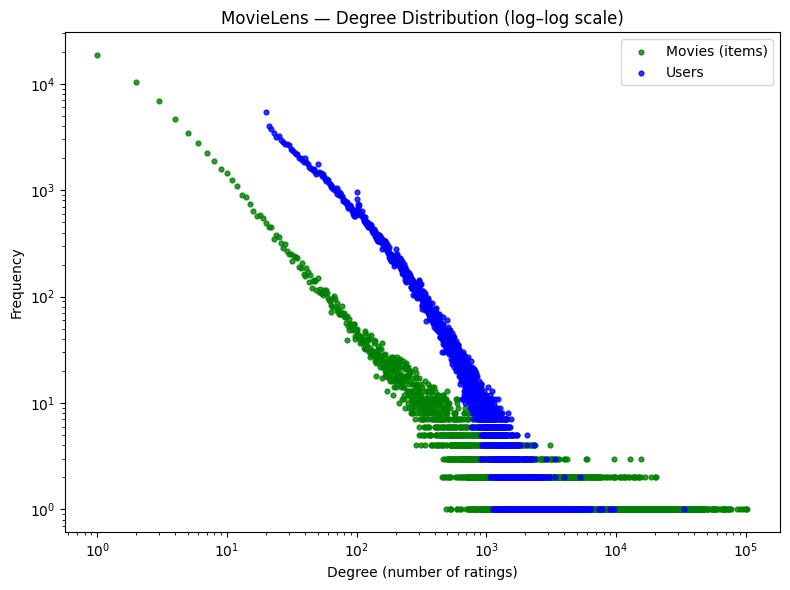

In [ ]:


# --------------------------------------------------------
# Compute degree counts from your FitData loader
# --------------------------------------------------------
movie_rating_counts = np.array([len(lst) for lst in data.data_by_movie], dtype=np.int32)
user_rating_counts  = np.array([len(lst) for lst in data.data_by_user], dtype=np.int32)

def degree_frequency(data):
    unique, counts = np.unique(data, return_counts=True)
    return unique, counts

movie_degree, movie_freq = degree_frequency(movie_rating_counts)
user_degree,  user_freq  = degree_frequency(user_rating_counts)

# --------------------------------------------------------
# Plot: Degree Distribution (log–log)
# --------------------------------------------------------
plt.figure(figsize=(8, 6))

plt.scatter(movie_degree, movie_freq, s=12, color='green',
            label='Movies (items)', alpha=0.8)
plt.scatter(user_degree, user_freq, s=12, color='blue',
            label='Users', alpha=0.8)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Degree (number of ratings)')
plt.ylabel('Frequency')
plt.title('MovieLens — Degree Distribution (log–log scale)')
plt.legend()

plt.tight_layout()

# --------------------------------------------------------
# SAVE AS PDF
# --------------------------------------------------------
plt.savefig("degree_distribution.pdf", format="pdf")

plt.show()


## 100k Dataset

### 2.1: Load the dataset

In [ ]:
import os
import csv
import numpy as np
import pandas as pd
from utils import FitData
import matplotlib.pyplot as plt
import zipfile


In [ ]:


# Ensure data folder exists
os.makedirs("data", exist_ok=True)

# Download MovieLens small dataset
!wget -q https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -O data/ml-latest-small.zip

# Unzip
with zipfile.ZipFile("data/ml-latest-small.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

# Check extracted folder
print("Contents of data folder:", os.listdir("data/"))

# Set correct data path
data_path = "data/ml-latest-small"
ratings_file = os.path.join(data_path, "ratings.csv")

# Make sure the file exists
if not os.path.exists(ratings_file):
    raise FileNotFoundError(f"{ratings_file} not found!")

# Load CSV into pandas
ratings = pd.read_csv(ratings_file)
print(ratings.head())
print("\nShape:", ratings.shape)


Contents of data folder: ['ml-latest-small', 'ml-32m', 'ml-latest-small.zip', 'ml-32m.zip']
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Shape: (100836, 4)


In [ ]:
file_path = os.path.join(data_path, data_file)

df = FitData(file_path)
df.load()


### 2.2: Split the dataset

In [ ]:
n_users = len(df.data_by_user)
n_movies = len(df.data_by_movie)

data_by_user_train = [[] for _ in range(n_users)]
data_by_user_test  = [[] for _ in range(n_users)]
data_by_movie_train = [[] for _ in range(n_movies)]
data_by_movie_test  = [[] for _ in range(n_movies)]

for i in range(n_users):
    ratings = df.data_by_user[i] # change variable name
    for movie_id, rating in ratings:
        if np.random.rand() < 0.9:
            data_by_user_train[i].append((movie_id, rating))
        else:
            data_by_user_test[i].append((movie_id, rating))

for i in range(n_users):
    user_id = df.idx_to_user_id[i]

    # train
    for movie_id, rating in data_by_user_train[i]:
        m_idx = df.movie_id_to_idx[movie_id]
        data_by_movie_train[m_idx].append((user_id, rating))

    # test
    for movie_id, rating in data_by_user_test[i]:
        m_idx = df.movie_id_to_idx[movie_id]
        data_by_movie_test[m_idx].append((user_id, rating))

In [ ]:
non_empty_users_train = sum(1 for u in data_by_user_train if len(u) > 0)
non_empty_users_test = sum(1 for u in data_by_user_test if len(u) > 0)

print(f"number of items in users train and test sets: {len(data_by_user_train)} , {len(data_by_user_test)}")
print(f"Number of users with ratings in train and test sets: {non_empty_users_train}, {non_empty_users_test}")

print()

non_empty_movies_train = sum(1 for u in data_by_movie_train if len(u) > 0)
non_empty_movies_test = sum(1 for u in data_by_movie_test if len(u) > 0)

print(f"number of items in movies train and test sets: {len(data_by_movie_train)}, {len(data_by_movie_test)}")
print(f"Number of movies with ratings in train and test sets: {non_empty_movies_train}, {non_empty_movies_test}")

number of items in users train and test sets: 610 , 610
Number of users with ratings in train and test sets: 610, 597

number of items in movies train and test sets: 9724, 9724
Number of movies with ratings in train and test sets: 9357, 3676


## 2.3: Bias Optimisation

Iter 1: Train RMSE=0.8049, Test RMSE=0.8842
Iter 2: Train RMSE=0.7892, Test RMSE=0.8705
Iter 3: Train RMSE=0.7880, Test RMSE=0.8699
Iter 4: Train RMSE=0.7878, Test RMSE=0.8698
Iter 5: Train RMSE=0.7877, Test RMSE=0.8698
Iter 6: Train RMSE=0.7877, Test RMSE=0.8697
Iter 7: Train RMSE=0.7877, Test RMSE=0.8697
Iter 8: Train RMSE=0.7877, Test RMSE=0.8696
Iter 9: Train RMSE=0.7877, Test RMSE=0.8696
Iter 10: Train RMSE=0.7876, Test RMSE=0.8695


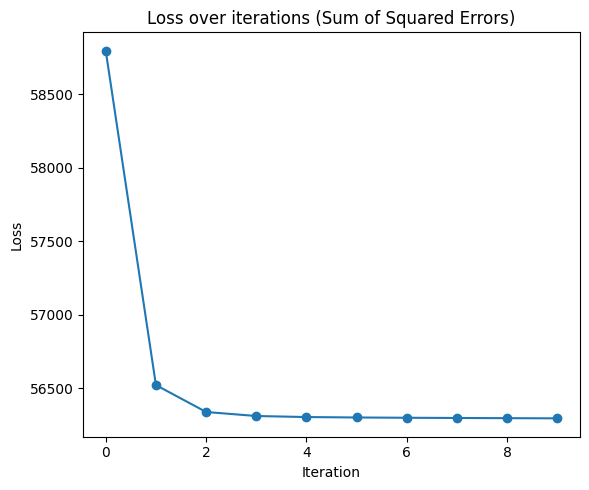

✓ Saved: 100k_loss_over_iterations.pdf


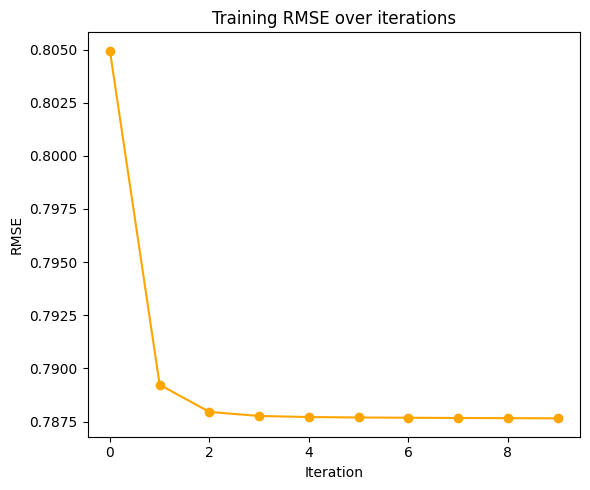

✓ Saved: 100k_train_rmse_over_iterations.pdf


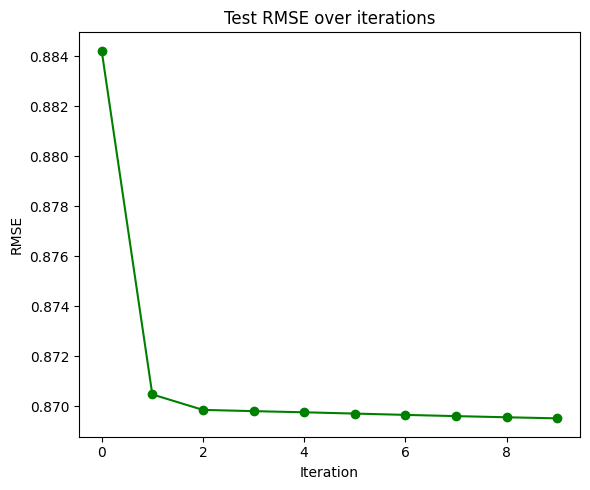

✓ Saved: 100k_test_rmse_over_iterations.pdf


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Parameters
# ---------------------------
M = n_users    # number of users
N = n_movies   # number of movies

lambd = 0.6    # regularization weight
gamma = 1e-8   # small smoothing term
num_iters = 10

user_biases = np.zeros(M)
item_biases = np.zeros(N)

# Create figures folder if it doesn't exist
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# ---------------------------
# Compute global mean rating
# ---------------------------
mu = np.mean([r for user_ratings in data_by_user_train for (_, r) in user_ratings])

# ---------------------------
# Track metrics
# ---------------------------
loss_history = []
rmse_history = []
rmse_test_history = []

# ---------------------------
# ALS bias-only iterations
# ---------------------------
for it in range(num_iters):
    # --- Update user biases ---
    for m in range(M):
        num = 0.0
        cnt = 0
        for (movie_id, r) in data_by_user_train[m]:
            n = df.movie_id_to_idx[movie_id]
            num += (r - mu - item_biases[n])
            cnt += 1
        if cnt > 0:
            user_biases[m] = num / (lambd + cnt + gamma)

    # --- Update item biases ---
    for n in range(N):
        num = 0.0
        cnt = 0
        for (user_id, r) in data_by_movie_train[n]:
            m_idx = df.user_id_to_idx[user_id]
            num += (r - mu - user_biases[m_idx])
            cnt += 1
        if cnt > 0:
            item_biases[n] = num / (lambd + cnt + gamma)

    # --- Compute training RMSE ---
    sq_err = 0.0
    count = 0
    for m in range(M):
        for movie_id, r in data_by_user_train[m]:
            n = df.movie_id_to_idx[movie_id]
            pred = mu + user_biases[m] + item_biases[n]
            sq_err += (r - pred) ** 2
            count += 1
    rmse_train = np.sqrt(sq_err / count)
    rmse_history.append(rmse_train)
    loss_history.append(sq_err)

    # --- Compute test RMSE ---
    sq_err_test = 0.0
    count_test = 0
    for m in range(M):
        for movie_id, r in data_by_user_test[m]:
            n = df.movie_id_to_idx[movie_id]
            pred = mu + user_biases[m] + item_biases[n]
            sq_err_test += (r - pred) ** 2
            count_test += 1
    rmse_test = np.sqrt(sq_err_test / count_test)
    rmse_test_history.append(rmse_test)

    print(f"Iter {it+1}: Train RMSE={rmse_train:.4f}, Test RMSE={rmse_test:.4f}")

# ---------------------------
# Plot and save Loss
# ---------------------------
plt.figure(figsize=(6,5))
plt.plot(loss_history, marker='o')
plt.title("Loss over iterations (Sum of Squared Errors)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "100k_loss_over_iterations.pdf"), format='pdf', bbox_inches='tight')
plt.show()  # display in kernel
plt.close()
print(f"✓ Saved: 100k_loss_over_iterations.pdf")

# ---------------------------
# Plot and save Training RMSE
# ---------------------------
plt.figure(figsize=(6,5))
plt.plot(rmse_history, marker='o', color='orange')
plt.title("Training RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "100k_train_rmse_over_iterations.pdf"), format='pdf', bbox_inches='tight')
plt.show()  # display in kernel
plt.close()
print(f"✓ Saved: 100k_train_rmse_over_iterations.pdf")

# ---------------------------
# Plot and save Test RMSE
# ---------------------------
plt.figure(figsize=(6,5))
plt.plot(rmse_test_history, marker='o', color='green')
plt.title("Test RMSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "100k_test_rmse_over_iterations.pdf"), format='pdf', bbox_inches='tight')
plt.show()  # display in kernel
plt.close()
print(f"✓ Saved: 100k_test_rmse_over_iterations.pdf")


## 100k Dataset with user and Item vector update

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils import FitData
import os
import math

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

class ALS:
    def __init__(self, df, data_by_user_train, data_by_user_test,
                 data_by_movie_train, data_by_movie_test,
                 K=25, lambd=0.01, num_iters=10, fig_dir="figures"):
        
        self.df = df
        self.data_by_user_train = data_by_user_train
        self.data_by_user_test = data_by_user_test
        self.data_by_movie_train = data_by_movie_train
        self.data_by_movie_test = data_by_movie_test

        self.M = len(df.data_by_user)
        self.N = len(df.data_by_movie)
        self.K = K
        self.lambd = lambd
        self.num_iters = num_iters

        # Initialize parameters
        self.user_biases = np.zeros(self.M)
        self.item_biases = np.zeros(self.N)
        self.U = 0.1 * np.random.randn(self.M, K)
        self.V = 0.1 * np.random.randn(self.N, K)
        self.mu = np.mean([r for ratings in self.data_by_user_train for (_, r) in ratings])

        # Tracking history
        self.loss_hist = []
        self.rmse_hist = []
        self.rmse_test_hist = []

        # Create figures folder
        self.fig_dir = fig_dir
        os.makedirs(self.fig_dir, exist_ok=True)

    def train(self):
        for it in range(self.num_iters):
            self.update_user_biases()
            self.update_item_biases()
            self.update_user_latent()
            self.update_item_latent()
            self.compute_metrics(it)

    # ---------------------------
    # Bias updates
    # ---------------------------
    def update_user_biases(self):
        for m in range(self.M):
            num = 0.0
            den = self.lambd
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                num += (r - self.mu - self.item_biases[n] - self.U[m] @ self.V[n])
                den += 1
            self.user_biases[m] = num / den

    def update_item_biases(self):
        for n in range(self.N):
            num = 0.0
            den = self.lambd
            for (user_id, r) in self.data_by_movie_train[n]:
                m = self.df.user_id_to_idx[user_id]
                num += (r - self.mu - self.user_biases[m] - self.U[m] @ self.V[n])
                den += 1
            self.item_biases[n] = num / den

    # ---------------------------
    # Latent factor updates
    # ---------------------------
    def update_user_latent(self):
        for m in range(self.M):
            A = self.lambd * np.eye(self.K)
            b = np.zeros(self.K)
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                v = self.V[n]
                A += np.outer(v, v)
                b += v * (r - self.mu - self.user_biases[m] - self.item_biases[n])
            self.U[m] = np.linalg.solve(A, b)

    def update_item_latent(self):
        for n in range(self.N):
            A = self.lambd * np.eye(self.K)
            b = np.zeros(self.K)
            for (user_id, r) in self.data_by_movie_train[n]:
                m = self.df.user_id_to_idx[user_id]
                u = self.U[m]
                A += np.outer(u, u)
                b += u * (r - self.mu - self.user_biases[m] - self.item_biases[n])
            self.V[n] = np.linalg.solve(A, b)

    # ---------------------------
    # Compute regularized NLL (loss) and RMSE
    # ---------------------------
    def compute_metrics(self, iteration):
        # Regularized negative log likelihood
        loss = 0.0
        for m in range(self.M):
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                loss += (r - pred) ** 2
        # Add regularization
        loss += self.lambd * (np.sum(self.user_biases**2) + np.sum(self.item_biases**2) +
                              np.sum(self.U**2) + np.sum(self.V**2))
        self.loss_hist.append(loss)

        # Training RMSE
        sq_err = 0.0
        count = 0
        for m in range(self.M):
            for (movie_id, r) in self.data_by_user_train[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                sq_err += (r - pred)**2
                count += 1
        rmse_train = np.sqrt(sq_err / count)
        self.rmse_hist.append(rmse_train)

        # Test RMSE
        sq_err_test = 0.0
        count_test = 0
        for m in range(self.M):
            for (movie_id, r) in self.data_by_user_test[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                sq_err_test += (r - pred)**2
                count_test += 1
        rmse_test = np.sqrt(sq_err_test / count_test)
        self.rmse_test_hist.append(rmse_test)

        print(f"Iter {iteration+1}: Loss={loss:.2f}, Train RMSE={rmse_train:.4f}, Test RMSE={rmse_test:.4f}")

    # ---------------------------
    # Plot metrics and save PDFs
    # ---------------------------
    def plot_metrics(self):
        # Loss
        plt.figure(figsize=(6,5))
        plt.plot(self.loss_hist, marker='o')
        plt.title("Regularized Negative Log Likelihood")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.tight_layout()
        plt.savefig(os.path.join(self.fig_dir, "loss_over_iterations.pdf"))
        plt.show()

        # Train RMSE
        plt.figure(figsize=(6,5))
        plt.plot(self.rmse_hist, marker='o', color='orange')
        plt.title("Training RMSE")
        plt.xlabel("Iteration")
        plt.ylabel("RMSE")
        plt.tight_layout()
        plt.savefig(os.path.join(self.fig_dir, "train_rmse_over_iterations.pdf"))
        plt.show()

        # Test RMSE
        plt.figure(figsize=(6,5))
        plt.plot(self.rmse_test_hist, marker='o', color='green')
        plt.title("Test RMSE")
        plt.xlabel("Iteration")
        plt.ylabel("RMSE")
        plt.tight_layout()
        plt.savefig(os.path.join(self.fig_dir, "test_rmse_over_iterations.pdf"))
        plt.show()


Iter 1: Loss=17093.93, Train RMSE=0.4249, Test RMSE=2.0486
Iter 2: Loss=13573.20, Train RMSE=0.3785, Test RMSE=1.9016
Iter 3: Loss=11836.40, Train RMSE=0.3529, Test RMSE=1.8604
Iter 4: Loss=10723.63, Train RMSE=0.3354, Test RMSE=1.8409
Iter 5: Loss=9938.44, Train RMSE=0.3224, Test RMSE=1.8230
Iter 6: Loss=9349.57, Train RMSE=0.3124, Test RMSE=1.8171
Iter 7: Loss=8885.13, Train RMSE=0.3042, Test RMSE=1.8127


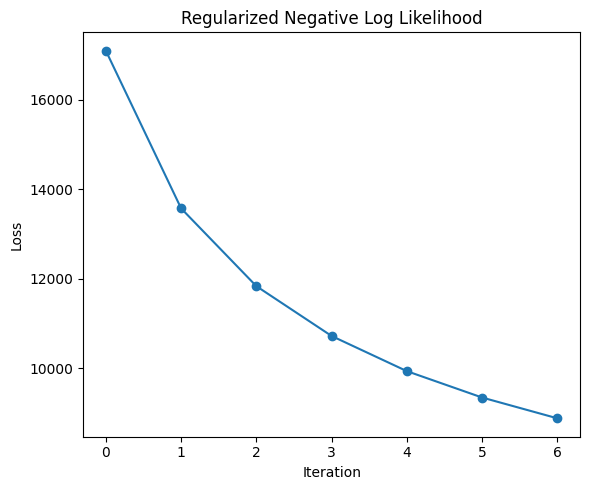

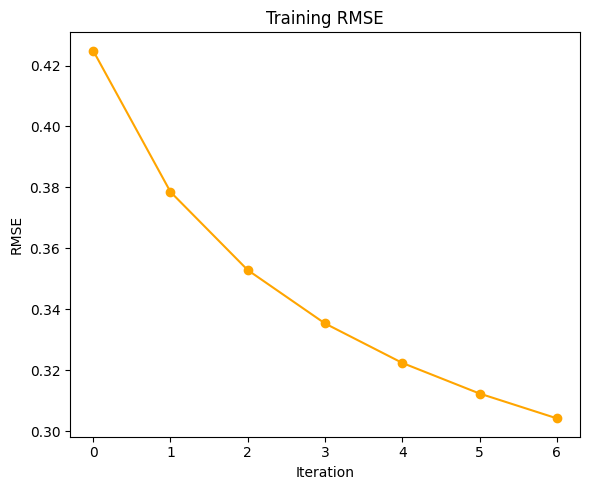

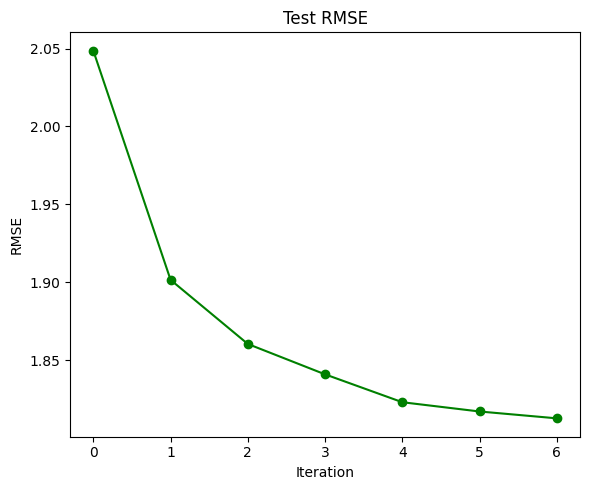

In [ ]:
# Initialize ALS
als_model = ALS(df, data_by_user_train, data_by_user_test,
                data_by_movie_train, data_by_movie_test,
                K=25, lambd=0.01, num_iters=7)

# Train the model
als_model.train()

# Plot metrics
als_model.plot_metrics()


## 32m Dataset training  (practical 3 and practical 4)

In [4]:
import os
from utils import FitData

DATA_DIR = "data/ml-32m/ml-32m"  # note the extra ml-32m folder created by unzip
RATINGS_CSV = os.path.join(DATA_DIR, "ratings.csv")
MOVIES_CSV = os.path.join(DATA_DIR, "movies.csv")

print("Ratings CSV exists:", os.path.exists(RATINGS_CSV))
print("Movies CSV exists:", os.path.exists(MOVIES_CSV))

df = FitData(RATINGS_CSV, MOVIES_CSV)
df.load()



Ratings CSV exists: True
Movies CSV exists: True


In [14]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numba import njit, prange

# --------------------------
# Ensure folders exist
# --------------------------
FIG_DIR = "figures"
MODEL_DIR = "models"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# --------------------------
# Numba-optimized update functions
# --------------------------
@njit(parallel=True)
def update_user_biases_numba(M, mu, lambd, U, V, item_biases,
                             user_items_flat, user_items_ptr, user_items_len,
                             user_ratings_flat, user_biases):
    for m in prange(M):
        start = user_items_ptr[m]
        ln = user_items_len[m]
        num = 0.0
        den = lambd
        Um = U[m]
        for k in range(ln):
            idx = start + k
            n = user_items_flat[idx]
            r = user_ratings_flat[idx]
            dot = 0.0
            Vn = V[n]
            for t in range(Vn.shape[0]):
                dot += Um[t] * Vn[t]
            num += r - mu - item_biases[n] - dot
            den += 1.0
        user_biases[m] = num / den if den > 0.0 else 0.0

@njit(parallel=True)
def update_item_biases_numba(N, mu, lambd, U, V, user_biases,
                             movie_users_flat, movie_users_ptr, movie_users_len,
                             movie_ratings_flat, item_biases):
    for n in prange(N):
        start = movie_users_ptr[n]
        ln = movie_users_len[n]
        num = 0.0
        den = lambd
        Vn = V[n]
        for k in range(ln):
            idx = start + k
            m = movie_users_flat[idx]
            r = movie_ratings_flat[idx]
            dot = 0.0
            Um = U[m]
            for t in range(Vn.shape[0]):
                dot += Um[t] * Vn[t]
            num += r - mu - user_biases[m] - dot
            den += 1.0
        item_biases[n] = num / den if den > 0.0 else 0.0

@njit(parallel=True)
def update_user_latent_numba(M, K, mu, lambd, U, V, user_biases, item_biases,
                             user_items_flat, user_items_ptr, user_items_len,
                             user_ratings_flat):
    for m in prange(M):
        start = user_items_ptr[m]
        ln = user_items_len[m]
        A = np.eye(K) * lambd
        b = np.zeros(K)
        ub = user_biases[m]
        for k in range(ln):
            idx = start + k
            n = user_items_flat[idx]
            r = user_ratings_flat[idx]
            Vn = V[n]
            ib = item_biases[n]
            b += Vn * (r - mu - ub - ib)
            for i in range(K):
                for j in range(K):
                    A[i,j] += Vn[i] * Vn[j]
        U[m] = np.linalg.solve(A, b)

@njit(parallel=True)
def update_item_latent_numba(N, K, mu, lambd, U, V, user_biases, item_biases,
                             movie_users_flat, movie_users_ptr, movie_users_len,
                             movie_ratings_flat):
    for n in prange(N):
        start = movie_users_ptr[n]
        ln = movie_users_len[n]
        A = np.eye(K) * lambd
        b = np.zeros(K)
        ib = item_biases[n]
        for k in range(ln):
            idx = start + k
            m = movie_users_flat[idx]
            r = movie_ratings_flat[idx]
            Um = U[m]
            ub = user_biases[m]
            b += Um * (r - mu - ub - ib)
            for i in range(K):
                for j in range(K):
                    A[i,j] += Um[i] * Um[j]
        V[n] = np.linalg.solve(A, b)

# --------------------------
# ALS Recommender Class
# --------------------------
class ALSRecommenderNumba:
    def __init__(self, df, K=20, lambd=0.05, num_iters=10, test_ratio=0.2):
        self.df = df
        self.K = K
        self.lambd = lambd
        self.num_iters = num_iters
        self.test_ratio = test_ratio

        self.M = self.df.num_users()
        self.N = self.df.num_movies()

        self.U = np.random.randn(self.M, K) * 0.1
        self.V = np.random.randn(self.N, K) * 0.1
        self.user_biases = np.zeros(self.M)
        self.item_biases = np.zeros(self.N)
        self.mu = 0.0

        self.loss_hist = []
        self.rmse_hist = []
        self.rmse_test_hist = []

        print(f"[LOG INIT] Numba ALS initialized: M={self.M}, N={self.N}, K={K}")

    # ----------------------
    # Train/test split and flatten
    # ----------------------
    def train_test_split(self):
        self.data_by_user_train = []
        self.data_by_user_test = []
        self.data_by_movie_train = [[] for _ in range(self.N)]
        self.data_by_movie_test  = [[] for _ in range(self.N)]

        for u_idx, ratings in enumerate(self.df.data_by_user):
            n_ratings = len(ratings)
            if n_ratings == 0:
                self.data_by_user_train.append([])
                self.data_by_user_test.append([])
                continue
            split_idx = int(math.ceil((1 - self.test_ratio) * n_ratings))
            train_ratings = ratings[:split_idx]
            test_ratings = ratings[split_idx:]
            self.data_by_user_train.append(train_ratings)
            self.data_by_user_test.append(test_ratings)

            for movie_id, r in train_ratings:
                m_idx = self.df.movie_id_to_idx[movie_id]
                self.data_by_movie_train[m_idx].append((self.df.idx_to_user_id[u_idx], r))
            for movie_id, r in test_ratings:
                m_idx = self.df.movie_id_to_idx[movie_id]
                self.data_by_movie_test[m_idx].append((self.df.idx_to_user_id[u_idx], r))

        # global mean
        all_train_ratings = [r for ratings in self.data_by_user_train for (_, r) in ratings]
        self.mu = np.mean(all_train_ratings) if all_train_ratings else 0.0

        # flatten arrays for Numba
        self._prepare_flat_arrays()

    def _prepare_flat_arrays(self):
        # Users
        user_offsets = np.zeros(self.M + 1, dtype=np.int32)
        total_user_entries = sum(len(r) for r in self.data_by_user_train)
        user_items_flat = np.empty(total_user_entries, dtype=np.int32)
        user_ratings_flat = np.empty(total_user_entries)
        pos = 0
        for m in range(self.M):
            ratings = self.data_by_user_train[m]
            user_offsets[m] = pos
            for movie_id, r in ratings:
                user_items_flat[pos] = self.df.movie_id_to_idx[movie_id]
                user_ratings_flat[pos] = r
                pos += 1
        user_offsets[self.M] = pos
        self.user_items_flat = user_items_flat
        self.user_items_ptr = user_offsets[:-1]
        self.user_items_len = user_offsets[1:] - user_offsets[:-1]
        self.user_ratings_flat = user_ratings_flat

        # Movies
        movie_offsets = np.zeros(self.N + 1, dtype=np.int32)
        total_movie_entries = sum(len(r) for r in self.data_by_movie_train)
        movie_users_flat = np.empty(total_movie_entries, dtype=np.int32)
        movie_ratings_flat = np.empty(total_movie_entries)
        pos = 0
        for n in range(self.N):
            ratings = self.data_by_movie_train[n]
            movie_offsets[n] = pos
            for user_id, r in ratings:
                movie_users_flat[pos] = self.df.user_id_to_idx[user_id]
                movie_ratings_flat[pos] = r
                pos += 1
        movie_offsets[self.N] = pos
        self.movie_users_flat = movie_users_flat
        self.movie_users_ptr = movie_offsets[:-1]
        self.movie_users_len = movie_offsets[1:] - movie_offsets[:-1]
        self.movie_ratings_flat = movie_ratings_flat

    # ----------------------
    # Fit (Numba-optimized ALS)
    # ----------------------
    def fit(self):
        for it in range(self.num_iters):
            update_user_biases_numba(
                self.M, self.mu, self.lambd, self.U, self.V, self.item_biases,
                self.user_items_flat, self.user_items_ptr, self.user_items_len,
                self.user_ratings_flat, self.user_biases
            )
            update_item_biases_numba(
                self.N, self.mu, self.lambd, self.U, self.V, self.user_biases,
                self.movie_users_flat, self.movie_users_ptr, self.movie_users_len,
                self.movie_ratings_flat, self.item_biases
            )
            update_user_latent_numba(
                self.M, self.K, self.mu, self.lambd, self.U, self.V, self.user_biases, self.item_biases,
                self.user_items_flat, self.user_items_ptr, self.user_items_len, self.user_ratings_flat
            )
            update_item_latent_numba(
                self.N, self.K, self.mu, self.lambd, self.U, self.V, self.user_biases, self.item_biases,
                self.movie_users_flat, self.movie_users_ptr, self.movie_users_len, self.movie_ratings_flat
            )

            rmse_train, rmse_test, loss = self.compute_metrics()
            self.rmse_hist.append(rmse_train)
            self.rmse_test_hist.append(rmse_test)
            self.loss_hist.append(loss)
            print(f"[ITER {it+1}] Loss={loss:.2f}, Train RMSE={rmse_train:.4f}, Test RMSE={rmse_test:.4f}")

    # ----------------------
    # Compute metrics
    # ----------------------
    def compute_metrics(self):
        sq_err, cnt = 0.0, 0
        for m in range(self.M):
            start = self.user_items_ptr[m]
            ln = self.user_items_len[m]
            for k in range(ln):
                idx = start + k
                n = int(self.user_items_flat[idx])
                r = float(self.user_ratings_flat[idx])
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                sq_err += (r - pred)**2
                cnt += 1
        rmse_train = math.sqrt(sq_err / cnt) if cnt else float('nan')

        sq_err_test, cnt_test = 0.0, 0
        for m in range(self.M):
            for movie_id, r in self.df.data_by_user_test[m]:
                n = self.df.movie_id_to_idx[movie_id]
                pred = self.mu + self.user_biases[m] + self.item_biases[n] + self.U[m] @ self.V[n]
                sq_err_test += (r - pred)**2
                cnt_test += 1
        rmse_test = math.sqrt(sq_err_test / cnt_test) if cnt_test else float('nan')

        reg_loss = self.lambd * (np.sum(self.U**2) + np.sum(self.V**2))
        total_loss = sq_err + reg_loss
        return rmse_train, rmse_test, total_loss

    # ----------------------
    # Save model
    # ----------------------
    def save_model(self, filename):
        filepath = os.path.join(MODEL_DIR, filename)
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)
        print(f"[LOG] Model saved to {filepath}")


# --------------------------
# Train multiple K values
# --------------------------
def train_multiple_K(df, K_list=[5, 10, 20], lambd=0.007, num_iters=10):
    trained_models = {}
    for K in K_list:
        print(f"\n[LOG] Training ALS with K={K}")
        als = ALSRecommenderNumba(df, K=K, lambd=lambd, num_iters=num_iters)
        als.train_test_split()
        als.fit()
        als.save_model(f"als_K{K}.pkl")
        trained_models[K] = als
    return trained_models

# --------------------------
# Plot comparative metrics
# --------------------------
def plot_comparative_metrics(trained_models):
    plt.figure(figsize=(8,5))
    for K, model in trained_models.items():
        plt.plot(model.loss_hist, marker='o', label=f'K={K}')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("ALS Loss over Iterations")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    for K, model in trained_models.items():
        plt.plot(model.rmse_hist, marker='o', label=f'Train K={K}')
        plt.plot(model.rmse_test_hist, marker='x', label=f'Test K={K}')
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.title("ALS Train/Test RMSE over Iterations")
    plt.grid(True)
    plt.legend()
    plt.show()

# --------------------------
# Load a saved model
# --------------------------
def load_model(K):
    filename = f"als_K{K}.pkl"
    filepath = os.path.join(MODEL_DIR, filename)
    if not os.path.exists(filepath):
        print(f"[ERROR] Model file {filename} not found in {MODEL_DIR}")
        return None
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"[LOG] Model loaded from {filepath}")
    return model

# --------------------------
# Run training, save models, and plot
# --------------------------
def run_als_pipeline(df, K_list=[5,10,20], lambd=0.05, num_iters=10):
    trained_models = train_multiple_K(df, K_list=K_list, lambd=lambd, num_iters=num_iters)
    plot_comparative_metrics(trained_models)
    return trained_models



In [15]:
import os
import csv
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

# --------------------------
# NUMBA OPTIMIZED UPDATES
# --------------------------
@njit(parallel=True)
def update_user_biases_numba(M, mu, lambd, U, V, item_biases,
                             user_items_flat, user_items_ptr, user_items_len,
                             user_ratings_flat, user_biases):
    for m in prange(M):
        start = user_items_ptr[m]
        ln = user_items_len[m]
        if ln == 0: continue
        num = 0.0
        den = lambd
        Um = U[m]
        for k in range(ln):
            idx = start + k
            n = user_items_flat[idx]
            r = user_ratings_flat[idx]
            dot = 0.0
            Vn = V[n]
            for t in range(Vn.shape[0]):
                dot += Um[t] * Vn[t]
            num += r - mu - item_biases[n] - dot
            den += 1.0
        user_biases[m] = num / den

@njit(parallel=True)
def update_item_biases_numba(N, mu, lambd, U, V, user_biases,
                             movie_users_flat, movie_users_ptr, movie_users_len,
                             movie_ratings_flat, item_biases):
    for n in prange(N):
        start = movie_users_ptr[n]
        ln = movie_users_len[n]
        if ln == 0: continue
        num = 0.0
        den = lambd
        Vn = V[n]
        for k in range(ln):
            idx = start + k
            m = movie_users_flat[idx]
            r = movie_ratings_flat[idx]
            dot = 0.0
            Um = U[m]
            for t in range(Vn.shape[0]):
                dot += Um[t] * Vn[t]
            num += r - mu - user_biases[m] - dot
            den += 1.0
        item_biases[n] = num / den

@njit(parallel=True)
def update_user_latent_numba(M, K, mu, lambd, U, V, user_biases, item_biases,
                             user_items_flat, user_items_ptr, user_items_len,
                             user_ratings_flat):
    eyes = np.eye(K) * lambd
    for m in prange(M):
        start = user_items_ptr[m]
        ln = user_items_len[m]
        if ln == 0: continue
        
        A = eyes.copy()
        b = np.zeros(K)
        ub = user_biases[m]
        
        for k in range(ln):
            idx = start + k
            n = user_items_flat[idx]
            r = user_ratings_flat[idx]
            Vn = V[n]
            ib = item_biases[n]
            error = r - mu - ub - ib
            b += Vn * error
            for i in range(K):
                for j in range(K):
                    A[i,j] += Vn[i] * Vn[j]
        U[m] = np.linalg.solve(A, b)

@njit(parallel=True)
def update_item_latent_numba(N, K, mu, lambd, U, V, user_biases, item_biases,
                             movie_users_flat, movie_users_ptr, movie_users_len,
                             movie_ratings_flat):
    eyes = np.eye(K) * lambd
    for n in prange(N):
        start = movie_users_ptr[n]
        ln = movie_users_len[n]
        if ln == 0: continue
        
        A = eyes.copy()
        b = np.zeros(K)
        ib = item_biases[n]
        
        for k in range(ln):
            idx = start + k
            m = movie_users_flat[idx]
            r = movie_ratings_flat[idx]
            Um = U[m]
            ub = user_biases[m]
            error = r - mu - ub - ib
            b += Um * error
            for i in range(K):
                for j in range(K):
                    A[i,j] += Um[i] * Um[j]
        V[n] = np.linalg.solve(A, b)

@njit(parallel=True)
def calc_rmse_numba(u_indices, m_indices, ratings, mu, U, V, user_biases, item_biases):
    sq_err = 0.0
    count = len(ratings)
    if count == 0: return 0.0
    
    for i in prange(count):
        u = u_indices[i]
        m = m_indices[i]
        r = ratings[i]
        dot = 0.0
        for k in range(U.shape[1]):
            dot += U[u, k] * V[m, k]
        pred = mu + user_biases[u] + item_biases[m] + dot
        sq_err += (r - pred)**2
        
    return np.sqrt(sq_err / count)

In [16]:
class FitData:
    def __init__(self, ratings_csv, movies_csv=None):
        self.ratings_csv = ratings_csv
        self.movies_csv = movies_csv

        # Mappings
        self.user_id_to_idx = {}
        self.idx_to_user_id = []
        self.movie_id_to_idx = {}
        self.idx_to_movie_id = []

        self.movie_id_to_title = {}  # store movie titles

        # Ratings data
        self.data_by_user = []
        self.data_by_movie = []

    def load(self):
        user_set = set()
        movie_set = set()

        # First pass: collect all unique IDs from ratings
        with open(self.ratings_csv, "r", encoding="utf-8") as f:
            reader = csv.reader(f)
            next(reader)  # skip header
            for row in reader:
                user_set.add(int(row[0]))
                movie_set.add(int(row[1]))

        # Create sorted lists of IDs
        self.idx_to_user_id = sorted(list(user_set))
        self.idx_to_movie_id = sorted(list(movie_set))

        # Create mappings
        self.user_id_to_idx = {uid: i for i, uid in enumerate(self.idx_to_user_id)}
        self.movie_id_to_idx = {mid: i for i, mid in enumerate(self.idx_to_movie_id)}

        # Initialize rating containers
        self.data_by_user = [[] for _ in range(len(self.idx_to_user_id))]
        self.data_by_movie = [[] for _ in range(len(self.idx_to_movie_id))]

        # Second pass: fill ratings
        with open(self.ratings_csv, "r", encoding="utf-8") as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                user_id = int(row[0])
                movie_id = int(row[1])
                rating = float(row[2])

                u_idx = self.user_id_to_idx[user_id]
                m_idx = self.movie_id_to_idx[movie_id]

                self.data_by_user[u_idx].append((movie_id, rating))
                self.data_by_movie[m_idx].append((user_id, rating))

        # Load movie titles if movies CSV is provided
        if self.movies_csv:
            with open(self.movies_csv, "r", encoding="utf-8") as f:
                reader = csv.reader(f)
                next(reader)  # skip header
                for row in reader:
                    movie_id = int(row[0])
                    title = row[1]
                    self.movie_id_to_title[movie_id] = title
        
        print(f"[LOG] Data loaded. Users: {len(self.idx_to_user_id)}, Movies: {len(self.idx_to_movie_id)}")

    def num_users(self):
        return len(self.idx_to_user_id)

    def num_movies(self):
        return len(self.idx_to_movie_id)

    def movie_titles(self, movie_ids):
        """Return titles for a list of movie IDs, fallback to ID string if missing."""
        return [self.movie_id_to_title.get(mid, str(mid)) for mid in movie_ids]

In [25]:
class ALSRecommender:
    def __init__(self, fit_data, K=10, lambd=0.04, num_iters=10, test_ratio=0.2):
        self.df = fit_data
        self.K = K
        self.lambd = lambd
        self.num_iters = num_iters
        self.test_ratio = test_ratio
        
        self.M = self.df.num_users()
        self.N = self.df.num_movies()
        
        # Init Latent Factors
        self.U = np.random.randn(self.M, K) * 0.1
        self.V = np.random.randn(self.N, K) * 0.1
        self.user_biases = np.zeros(self.M)
        self.item_biases = np.zeros(self.N)
        self.mu = 0.0
        
        self.rmse_hist = []
        self.rmse_test_hist = []

    def train_test_split(self):
        print("[LOG] Flattening FitData structure for Numba...")
        
        # Convert List-of-Lists (from FitData) to Flat Arrays (for Numba)
        train_u, train_i, train_r = [], [], []
        test_u, test_i, test_r = [], [], []
        
        for u_idx, ratings in enumerate(self.df.data_by_user):
            for (movie_id, rating) in ratings:
                m_idx = self.df.movie_id_to_idx[movie_id]
                if np.random.rand() < self.test_ratio:
                    test_u.append(u_idx)
                    test_i.append(m_idx)
                    test_r.append(rating)
                else:
                    train_u.append(u_idx)
                    train_i.append(m_idx)
                    train_r.append(rating)
        
        self.train_users = np.array(train_u, dtype=np.int32)
        self.train_items = np.array(train_i, dtype=np.int32)
        self.train_ratings = np.array(train_r, dtype=np.float64)
        
        self.test_users = np.array(test_u, dtype=np.int32)
        self.test_items = np.array(test_i, dtype=np.int32)
        self.test_ratings = np.array(test_r, dtype=np.float64)
        
        self.mu = np.mean(self.train_ratings) if len(self.train_ratings) > 0 else 0.0
        print(f"[LOG] Split complete. Train: {len(self.train_ratings)}, Test: {len(self.test_ratings)}")
        
        # Build CSR-like structures
        print("[LOG] Building CSR index structures...")
        
        # User-centric
        sort_u = np.argsort(self.train_users)
        self.user_items_flat = self.train_items[sort_u]
        self.user_ratings_flat = self.train_ratings[sort_u]
        sorted_users = self.train_users[sort_u]
        self.user_items_ptr = np.zeros(self.M + 1, dtype=np.int32)
        counts_u = np.bincount(sorted_users, minlength=self.M)
        self.user_items_ptr[1:] = np.cumsum(counts_u)
        self.user_items_len = counts_u.astype(np.int32)

        # Item-centric
        sort_m = np.argsort(self.train_items)
        self.movie_users_flat = self.train_users[sort_m]
        self.movie_ratings_flat = self.train_ratings[sort_m]
        sorted_movies = self.train_items[sort_m]
        self.movie_users_ptr = np.zeros(self.N + 1, dtype=np.int32)
        counts_m = np.bincount(sorted_movies, minlength=self.N)
        self.movie_users_ptr[1:] = np.cumsum(counts_m)
        self.movie_users_len = counts_m.astype(np.int32)

    def fit(self):
        print(f"[LOG] Training ALS with K={self.K}...")
        for it in range(self.num_iters):
            t0 = time.time()
            update_user_biases_numba(
                self.M, self.mu, self.lambd, self.U, self.V, self.item_biases,
                self.user_items_flat, self.user_items_ptr, self.user_items_len,
                self.user_ratings_flat, self.user_biases
            )
            update_item_biases_numba(
                self.N, self.mu, self.lambd, self.U, self.V, self.user_biases,
                self.movie_users_flat, self.movie_users_ptr, self.movie_users_len,
                self.movie_ratings_flat, self.item_biases
            )
            update_user_latent_numba(
                self.M, self.K, self.mu, self.lambd, self.U, self.V, self.user_biases, self.item_biases,
                self.user_items_flat, self.user_items_ptr, self.user_items_len, self.user_ratings_flat
            )
            update_item_latent_numba(
                self.N, self.K, self.mu, self.lambd, self.U, self.V, self.user_biases, self.item_biases,
                self.movie_users_flat, self.movie_users_ptr, self.movie_users_len, self.movie_ratings_flat
            )
            
            # Metrics (Approximate Train RMSE for speed)
            sample_size = min(100000, len(self.train_users))
            idx = np.random.choice(len(self.train_users), sample_size, replace=False)
            rmse_train = calc_rmse_numba(self.train_users[idx], self.train_items[idx], self.train_ratings[idx],
                                         self.mu, self.U, self.V, self.user_biases, self.item_biases)
            rmse_test = calc_rmse_numba(self.test_users, self.test_items, self.test_ratings,
                                        self.mu, self.U, self.V, self.user_biases, self.item_biases)
            
            self.rmse_hist.append(rmse_train)
            self.rmse_test_hist.append(rmse_test)
            print(f"  [Iter {it+1}] Time: {time.time()-t0:.1f}s | Train RMSE: {rmse_train:.4f} | Test RMSE: {rmse_test:.4f}")

    def save_model(self, filename):
        # Temporarily remove heavy training data to save disk space
        temp_data = (self.train_users, self.train_items, self.train_ratings,
                     self.test_users, self.test_items, self.test_ratings,
                     self.user_items_flat, self.user_ratings_flat,
                     self.movie_users_flat, self.movie_ratings_flat)
        self.train_users = self.train_items = self.train_ratings = None
        self.test_users = self.test_items = self.test_ratings = None
        self.user_items_flat = self.user_ratings_flat = None
        self.movie_users_flat = self.movie_ratings_flat = None
        self.df = None # Don't pickle the CSV loader data
        
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        print(f"[LOG] Model saved to {filename}")
        
        # Restore data to continue execution if needed
        (self.train_users, self.train_items, self.train_ratings,
         self.test_users, self.test_items, self.test_ratings,
         self.user_items_flat, self.user_ratings_flat,
         self.movie_users_flat, self.movie_ratings_flat) = temp_data

In [26]:
def run_multi_k_training(fit_data, k_values=[5, 10, 20], num_iters=20):
    results = {}
    for K in k_values:
        print(f"\n================ STARTING K={K} (Iterations={num_iters}) ================")
        
        # Pass num_iters here
        model = ALSRecommender(fit_data, K=K, lambd=0.1, num_iters=num_iters) 
        
        model.train_test_split()
        model.fit()
        
        filename = f"als_model_k{K}.pkl"
        model.save_model(filename)
        results[K] = model 
        
    return results

def plot_comparisons(model_dict, save_path="figures/als_training_comparison.pdf"):
    plt.figure(figsize=(10, 6))
    for K, model in model_dict.items():
        plt.plot(model.rmse_test_hist, marker='o', label=f'Test K={K}')
        plt.plot(model.rmse_hist, linestyle='--', alpha=0.5, label=f'Train K={K}')
    
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('ALS Training Progress')
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"[LOG] Plot saved to {save_path}")
    
    plt.show()


def load_and_test_pickle(filename, fit_data_obj):
    if not os.path.exists(filename):
        print(f"[ERROR] File {filename} not found.")
        return

    print(f"\n[LOG] Loading {filename}...")
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    
    print(f"  > Loaded Model K={model.K}, Lambda={model.lambd}")
    print(f"  > Final Test RMSE stored: {model.rmse_test_hist[-1]:.4f}")
    
    # Sanity Check Prediction
    if len(fit_data_obj.idx_to_user_id) > 0:
        # 1. Get a real user ID
        real_user_id = fit_data_obj.idx_to_user_id[0] 
        u_idx = fit_data_obj.user_id_to_idx[real_user_id]
        
        print(f"  > Predictions for User {real_user_id}:")
        
        # 2. Pick 5 random internal movie indices
        random_indices = np.random.randint(0, model.N, 5)
        
        # 3. Convert internal indices -> Real Movie IDs
        real_movie_ids = [fit_data_obj.idx_to_movie_id[i] for i in random_indices]
        
        # 4. Get Titles (The Class in Cell 2 has this method)
        titles = fit_data_obj.movie_titles(real_movie_ids)
        
        for i, m_idx in enumerate(random_indices):
            title = titles[i]
            # Predict
            pred = model.mu + model.user_biases[u_idx] + model.item_biases[m_idx] + \
                   np.dot(model.U[u_idx], model.V[m_idx])
            
            print(f"    Movie: '{title}' -> Pred Rating: {pred:.2f}")


def get_recommendations(model, user_idx, exclude_indices=set(), top_n=10):
    """
    Calculates scores for all items for a specific user and returns top N.
    """
    # Score = mu + b_u + b_i + U . V
    # Calculate dot product for this user against ALL items
    scores = model.mu + model.user_biases[user_idx] + model.item_biases + \
             (model.V @ model.U[user_idx])
    
    # Set scores of already rated items to negative infinity so they aren't recommended
    for m_idx in exclude_indices:
        scores[m_idx] = -np.inf
        
    # Get top N indices
    # argsort gives ascending, so we take last N and reverse
    top_indices = np.argsort(scores)[-top_n:][::-1]
    return top_indices

def get_polarizing_movies(model, top_n=10):
    """
    Returns indices of movies with the largest vector norms.
    Large norm = strong latent traits (loved by some, hated by others).
    """
    # Calculate Euclidean norm for every movie vector in V
    norms = np.linalg.norm(model.V, axis=1)
    
    # Get indices of largest norms
    top_indices = np.argsort(norms)[-top_n:][::-1]
    
    return list(zip(top_indices, norms[top_indices]))

def optimize_single_user(model, user_idx, rated_item_indices, ratings, num_iters=10):
    """
    Solves the ALS equation for a SINGLE user to update their vector U[user_idx]
    based on new ratings.
    """
    K = model.K
    lambd = model.lambd
    
    # Slice the V matrix to get only the movies the user rated
    V_batch = model.V[rated_item_indices]  # shape: (n_rated, K)
    item_biases_batch = model.item_biases[rated_item_indices]
    
    # Pre-calculate V^T * V + lambda * I (This is the 'A' matrix in Ax=b)
    # Note: For a single user with few ratings, we can do this simply
    A = np.dot(V_batch.T, V_batch) + np.eye(K) * lambd
    
    for _ in range(num_iters):
        # Update User Bias
        # b_u = sum(r - mu - b_i - U.V) / (n_ratings + lambda)
        pred_ratings = np.dot(V_batch, model.U[user_idx])
        errors = ratings - model.mu - item_biases_batch - pred_ratings
        model.user_biases[user_idx] = np.sum(errors + model.user_biases[user_idx]) / (len(ratings) + lambd)
        
        # Update User Latent Vector (U)
        # b = V^T * (ratings - mu - b_u - b_i)
        residual = ratings - model.mu - model.user_biases[user_idx] - item_biases_batch
        b = np.dot(V_batch.T, residual)
        
        # Solve Ax = b
        model.U[user_idx] = np.linalg.solve(A, b)

In [21]:
DATA_DIR = "data/ml-32m/ml-32m" 
RATINGS_CSV = os.path.join(DATA_DIR, "ratings.csv")
MOVIES_CSV = os.path.join(DATA_DIR, "movies.csv")

# Initialize and Load
if os.path.exists(RATINGS_CSV):
    df = FitData(RATINGS_CSV, MOVIES_CSV)
    df.load()
else:
    print("CSV files not found.")

[LOG] Data loaded. Users: 200948, Movies: 84432


In [50]:
# Run Training
trained_models = run_multi_k_training(df, k_values=[5, 10, 20], num_iters=8)



================ STARTING K=5 (Iterations=8) ================
[LOG] Flattening FitData structure for Numba...
[LOG] Split complete. Train: 25602245, Test: 6397959
[LOG] Building CSR index structures...
[LOG] Training ALS with K=5...
  [Iter 1] Time: 1.4s | Train RMSE: 0.8333 | Test RMSE: 0.8917
  [Iter 2] Time: 1.3s | Train RMSE: 0.7968 | Test RMSE: 0.8583
  [Iter 3] Time: 1.2s | Train RMSE: 0.7772 | Test RMSE: 0.8366
  [Iter 4] Time: 1.3s | Train RMSE: 0.7605 | Test RMSE: 0.8223
  [Iter 5] Time: 1.2s | Train RMSE: 0.7537 | Test RMSE: 0.8137
  [Iter 6] Time: 1.3s | Train RMSE: 0.7533 | Test RMSE: 0.8086
  [Iter 7] Time: 1.3s | Train RMSE: 0.7495 | Test RMSE: 0.8056
  [Iter 8] Time: 1.2s | Train RMSE: 0.7456 | Test RMSE: 0.8037
[LOG] Model saved to als_model_k5.pkl

================ STARTING K=10 (Iterations=8) ================
[LOG] Flattening FitData structure for Numba...
[LOG] Split complete. Train: 25599761, Test: 6400443
[LOG] Building CSR index structures...
[LOG] Training ALS w

[LOG] Plot saved to figures/als_training_comparison.pdf


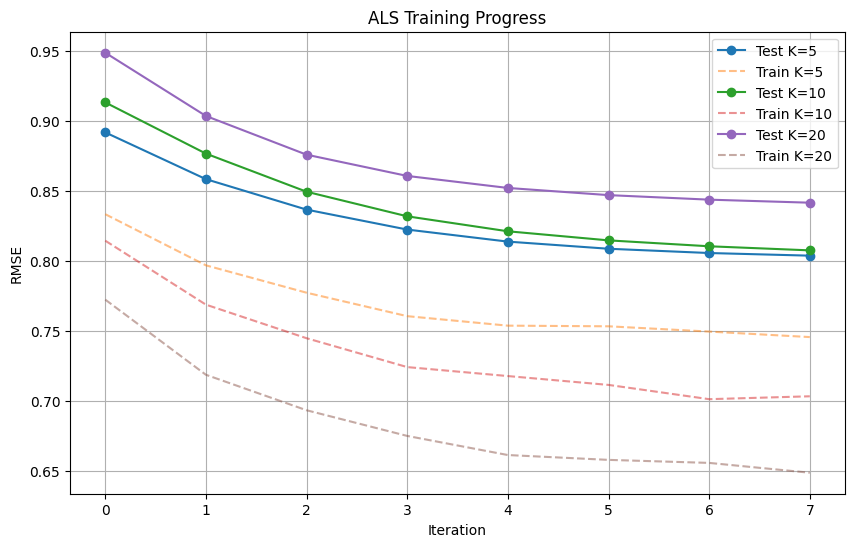

In [51]:
plot_comparisons(trained_models)


In [ ]:
# Test loading the K=10 model and making predictions
load_and_test_pickle("models/als_model_k10.pkl", df)


[LOG] Loading als_model_k10.pkl...
  > Loaded Model K=10, Lambda=0.1
  > Final Test RMSE stored: 0.8075
  > Predictions for User 1:
    Movie: 'Wild Geese II (1985)' -> Pred Rating: 4.74
    Movie: 'Pornographers, The (Erogotoshi-tachi yori: Jinruigaku nyûmon) (1966)' -> Pred Rating: 3.72
    Movie: 'Norm of the North (2016)' -> Pred Rating: 0.50
    Movie: 'Barbie in Rock 'N Royals (2015)' -> Pred Rating: 4.02
    Movie: 'About Love (2020)' -> Pred Rating: 2.93


In [56]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------
# 0. PRE-CALCULATIONS & FILTERS
# -------------------------------------------
# Ensure we have the popularity data
if 'movie_counts' not in locals():
    print("[INFO] Calculating movie popularity...")
    movie_counts = np.array([len(ratings) for ratings in df.data_by_movie])

# --- FIXING THE FILTERS ---
MIN_RATINGS = 500      # Keep this (removes noise)
MIN_NORM = 0.0         # CHANGED FROM 5.0 to 0.0. Your vectors are smaller than 5.0.

# -------------------------------------------
# 1. SETUP: FIND TOY STORY
# -------------------------------------------
target_id = 1 # Toy Story
target_title = df.movie_id_to_title.get(target_id, "Unknown")

# Safety check
if target_id not in df.movie_id_to_idx:
    for mid, title in df.movie_id_to_title.items():
        if "Toy Story" in title:
            target_id = mid
            target_title = title
            break

print(f"[INFO] Generating recommendations for: '{target_title}'")

# -------------------------------------------
# 2. HELPER: COSINE SIMILARITY
# -------------------------------------------
def get_cosine_recommendations(model, target_idx, counts, norms, top_n=10):
    # 1. Get the vector for the target movie
    target_vector = model.V[target_idx]
    target_norm = np.linalg.norm(target_vector)
    
    # 2. Dot product of Target vs ALL movies
    dot_products = model.V @ target_vector
    
    # 3. Calculate Similarity (-1.0 to 1.0)
    # Avoid division by zero
    safe_norms = norms.copy()
    safe_norms[safe_norms == 0] = 1e-9
    
    similarities = dot_products / (safe_norms * target_norm)
    
    # 4. APPLY FILTERS (Masking)
    # Set similarity to -2.0 (worse than -1.0) to ensure they are at the bottom
    similarities[counts < MIN_RATINGS] = -2.0
    similarities[norms < MIN_NORM] = -2.0
    similarities[target_idx] = -2.0 # Don't recommend the movie itself
    
    # 5. Get Top N
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    return top_indices, similarities[top_indices]

# -------------------------------------------
# 3. GENERATE REPORT CONTENT
# -------------------------------------------
text_output = []
text_output.append("ALS RECOMMENDATION REPORT")
text_output.append("=========================")
text_output.append(f"Base Movie: {target_title}")
text_output.append(f"Filters: Ratings > {MIN_RATINGS}\n")

for K, model in trained_models.items():
    header = f"--- Results for K={K} ---"
    print(f"{header}")
    text_output.append(header)
    
    target_idx = df.movie_id_to_idx[target_id]
    item_norms = np.linalg.norm(model.V, axis=1)
    
    # --- A. RECOMMENDATIONS ---
    rec_indices, rec_scores = get_cosine_recommendations(
        model, target_idx, movie_counts, item_norms, top_n=10
    )
    
    text_output.append("[Top 10 Similar Movies]")
    rec_ids = [df.idx_to_movie_id[i] for i in rec_indices]
    rec_titles = df.movie_titles(rec_ids)
    
    for rank, (title, score) in enumerate(zip(rec_titles, rec_scores), 1):
        line = f"  {rank}. {title} (Similarity: {score:.4f})"
        print(line)
        text_output.append(line)
        
    # --- B. POLARIZING MOVIES ---
    text_output.append("\n[Top 10 Polarizing Movies]")
    
    # Filter indices by popularity
    pop_indices = np.where(movie_counts >= MIN_RATINGS)[0]
    pop_norms = item_norms[pop_indices]
    
    # Sort by Norm Descending
    sorted_args = np.argsort(pop_norms)[-10:][::-1]
    top_pol_indices = pop_indices[sorted_args]
    
    for rank, m_idx in enumerate(top_pol_indices, 1):
        real_id = df.idx_to_movie_id[m_idx]
        title = df.movie_id_to_title.get(real_id, str(real_id))
        norm_val = item_norms[m_idx]
        line = f"  {rank}. {title} (Norm: {norm_val:.4f})"
        text_output.append(line)
        
    text_output.append("\n") # Spacer

# -------------------------------------------
# 4. SAVE TO PDF
# -------------------------------------------
print("\n[INFO] Saving report to 'recommendations_report.pdf'...")

full_text = "\n".join(text_output)
# Dynamic height calculation
fig_height = max(11, len(text_output) * 0.25)

plt.figure(figsize=(8.5, fig_height))
plt.axis('off')

# Render text
plt.text(0.05, 0.98, full_text, 
         transform=plt.gca().transAxes, 
         fontsize=10, 
         verticalalignment='top', 
         family='monospace')

plt.savefig("recommendations_report.pdf", bbox_inches='tight')
plt.close()
print("[INFO] PDF Saved successfully.")


[INFO] Generating recommendations for: 'Toy Story (1995)'
--- Results for K=5 ---
  1. Toy Story 2 (1999) (Similarity: 0.9952)
  2. Toy Story 3 (2010) (Similarity: 0.9817)
  3. Death Note: Desu nôto (2006–2007) (Similarity: 0.9810)
  4. School of Rock (2003) (Similarity: 0.9660)
  5. Monsters, Inc. (2001) (Similarity: 0.9651)
  6. Aladdin (1992) (Similarity: 0.9648)
  7. Bug's Life, A (1998) (Similarity: 0.9623)
  8. Finding Nemo (2003) (Similarity: 0.9623)
  9. Incredibles, The (2004) (Similarity: 0.9516)
  10. Four Musketeers, The (1974) (Similarity: 0.9477)
--- Results for K=10 ---
  1. Toy Story 2 (1999) (Similarity: 0.9754)
  2. Bug's Life, A (1998) (Similarity: 0.9219)
  3. Toy Story 3 (2010) (Similarity: 0.8697)
  4. Aladdin (1992) (Similarity: 0.8662)
  5. Beauty and the Beast (1991) (Similarity: 0.8505)
  6. Incredibles, The (2004) (Similarity: 0.8448)
  7. Finding Nemo (2003) (Similarity: 0.8410)
  8. Ratatouille (2007) (Similarity: 0.8258)
  9. Monsters, Inc. (2001) (Similar

[INFO] Generating Maps for target: Toy Story (1995)
Processing Map for K=5...
[INFO] Saved movie_map_annotated_K5.pdf


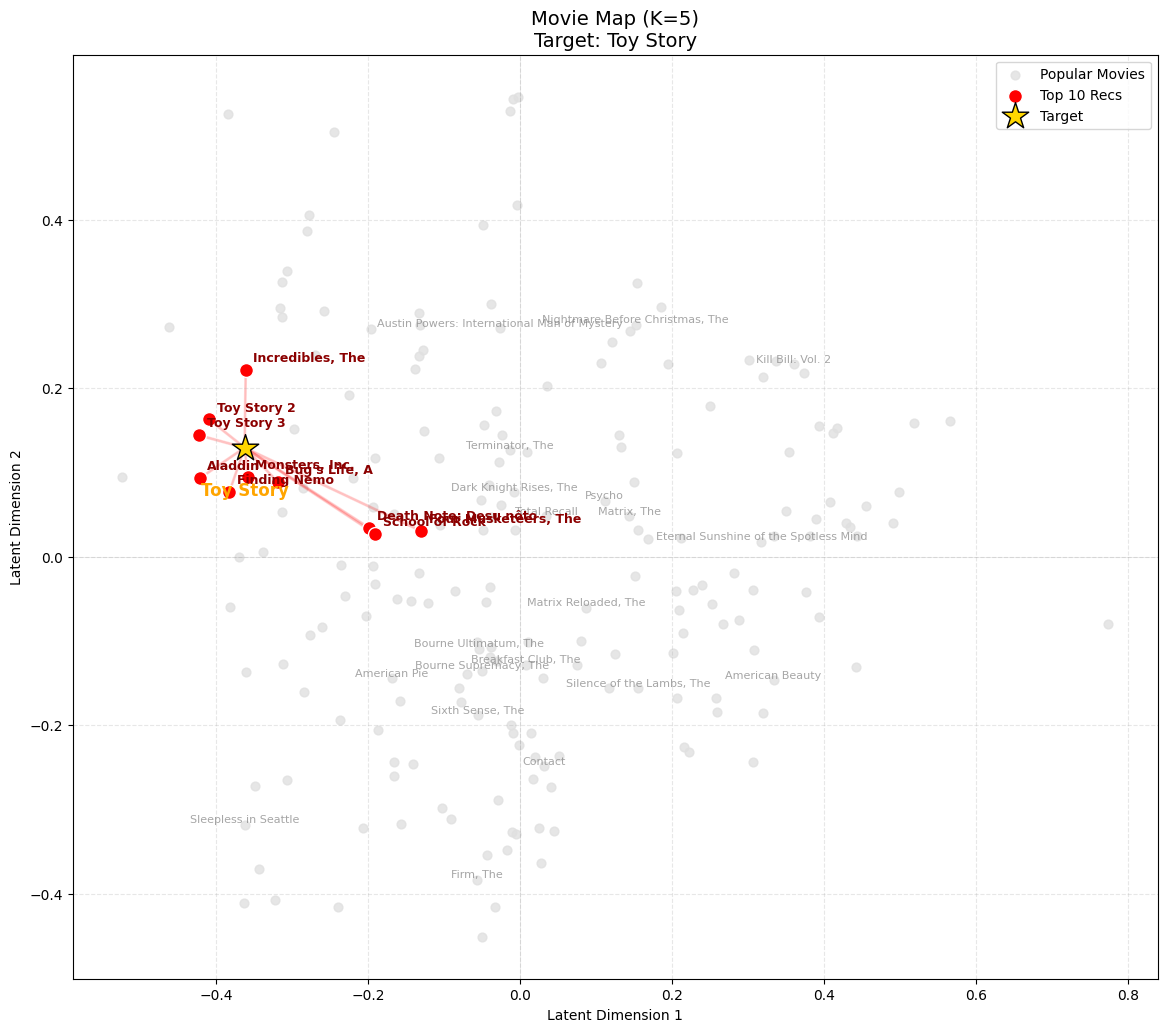

Processing Map for K=10...
[INFO] Saved movie_map_annotated_K10.pdf


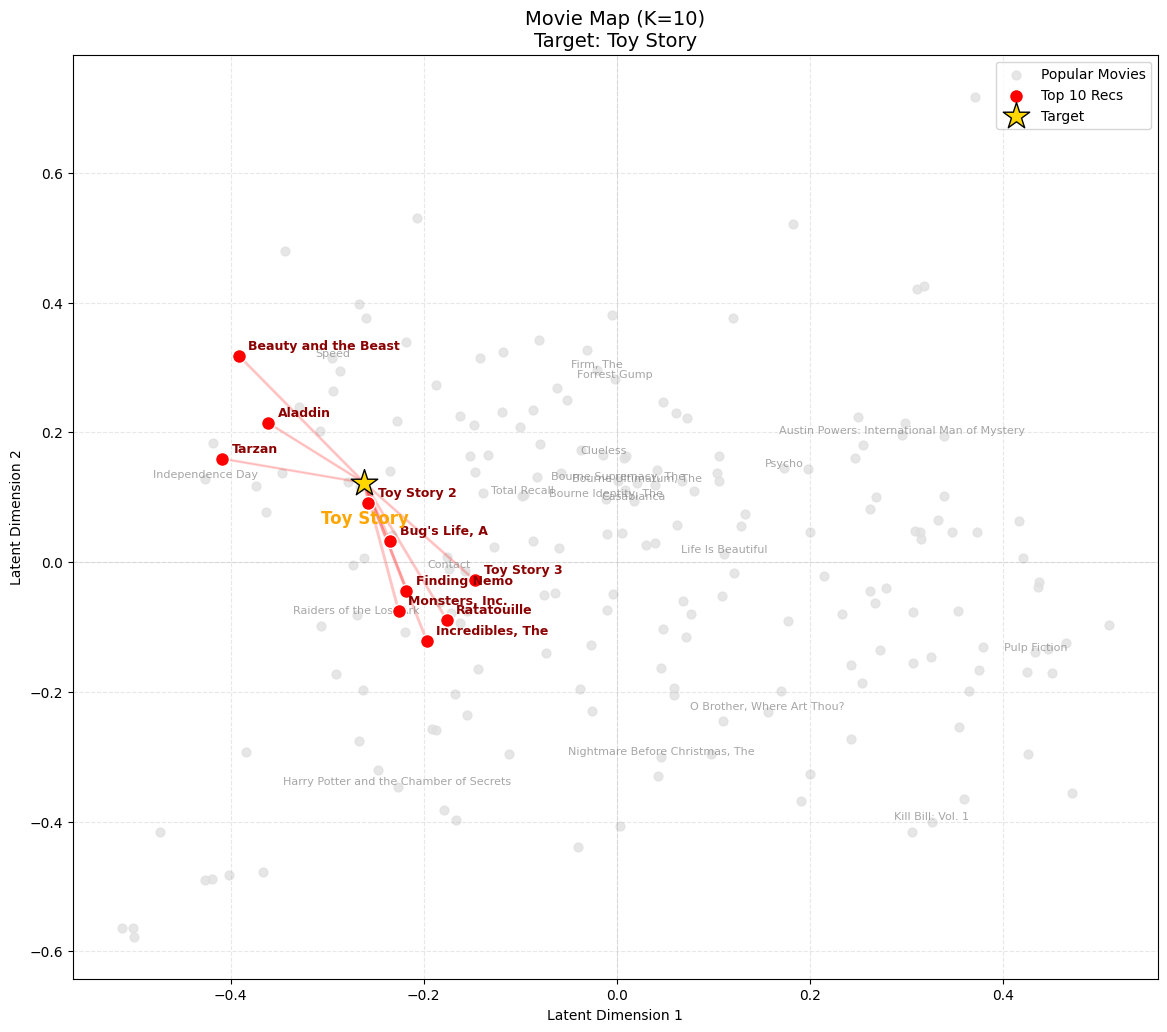

Processing Map for K=20...
[INFO] Saved movie_map_annotated_K20.pdf


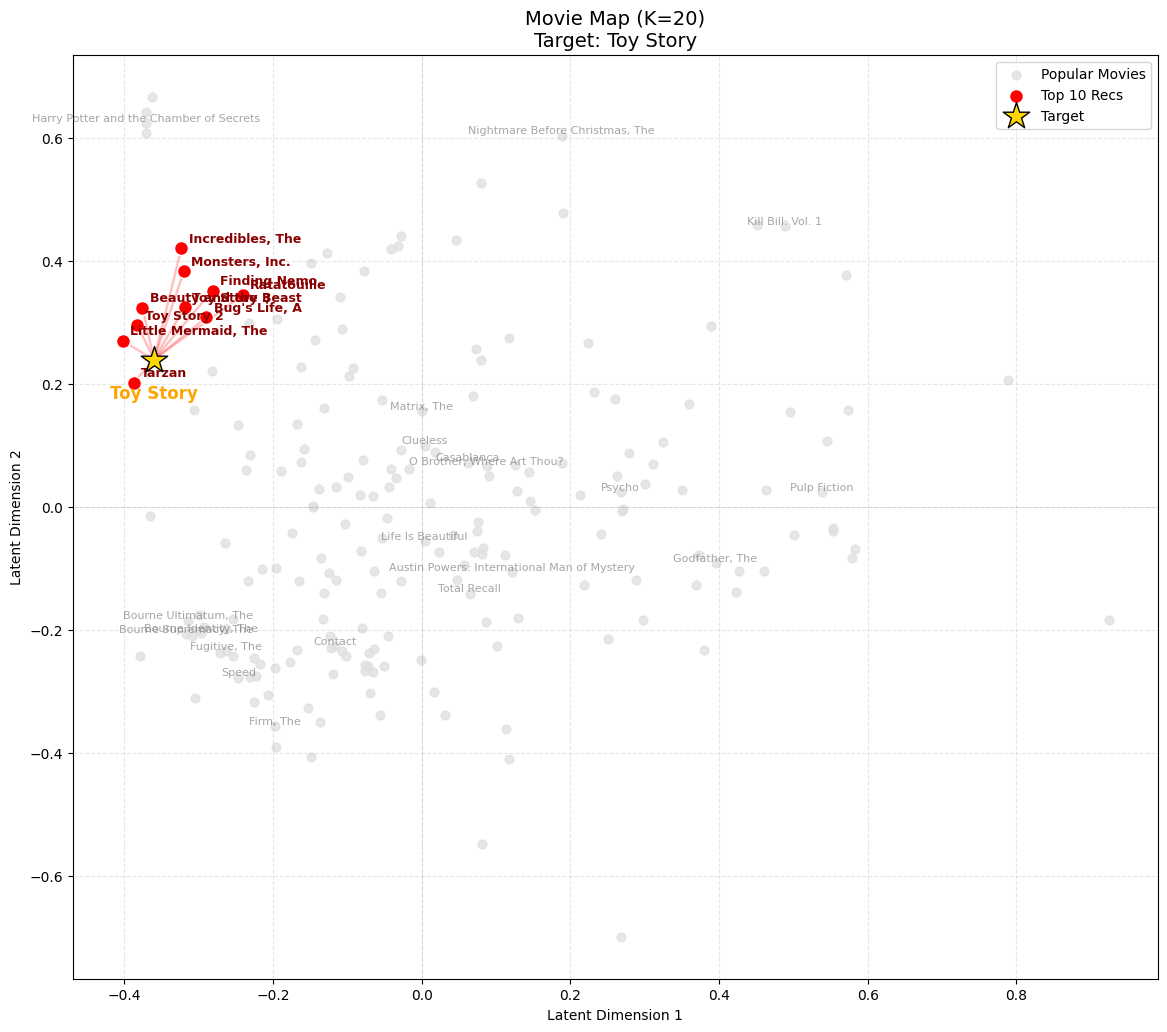

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# -------------------------------------------
# CONFIGURATION
# -------------------------------------------
MIN_RATINGS = 500  # Filter for quality
TARGET_ID = 1      # Toy Story
TOP_N_CONTEXT = 200 # How many popular movies to show in background

# Ensure popularity counts exist
if 'movie_counts' not in locals():
    movie_counts = np.array([len(ratings) for ratings in df.data_by_movie])

# -------------------------------------------
# HELPER: CLEAN TITLES
# -------------------------------------------
def clean_title(t):
    # "Toy Story (1995)" -> "Toy Story"
    return t.split('(')[0].strip()

# -------------------------------------------
# MAIN PLOTTING FUNCTION
# -------------------------------------------
def generate_recommendation_maps(models, df, counts, target_id):
    
    # Find Target Title
    target_title = df.movie_id_to_title.get(target_id, "Target")
    target_idx = df.movie_id_to_idx[target_id]
    print(f"[INFO] Generating Maps for target: {target_title}")

    for K, model in models.items():
        print(f"Processing Map for K={K}...")
        
        # --- 1. GET RECOMMENDATIONS (Logic from previous step) ---
        # Get vector and norms
        target_vec = model.V[target_idx]
        norms = np.linalg.norm(model.V, axis=1)
        
        # Cosine Sim
        safe_norms = norms.copy()
        safe_norms[safe_norms == 0] = 1e-9
        sims = (model.V @ target_vec) / (safe_norms * np.linalg.norm(target_vec))
        
        # Filter
        sims[counts < MIN_RATINGS] = -2.0
        sims[target_idx] = -2.0
        
        # Get Top 10 Indices
        rec_indices = np.argsort(sims)[-10:][::-1]
        
        # --- 2. PREPARE PLOT DATA ---
        # We want to plot: Target + Recs + Top 200 Popular (for context)
        pop_indices = np.argsort(counts)[-TOP_N_CONTEXT:]
        
        # Combine unique indices
        all_indices = np.unique(np.concatenate(([target_idx], rec_indices, pop_indices)))
        
        # Extract Vectors
        vectors = model.V[all_indices]
        
        # --- 3. PCA REDUCTION ---
        pca = PCA(n_components=2)
        coords = pca.fit_transform(vectors)
        
        # Create a mapping from original index -> new PCA coordinate index
        idx_map = {original: i for i, original in enumerate(all_indices)}
        
        # --- 4. PLOTTING ---
        plt.figure(figsize=(12, 10))
        ax = plt.gca()
        
        # A. Plot "Context" Movies (Popular ones)
        context_x, context_y = [], []
        for idx in pop_indices:
            if idx not in rec_indices and idx != target_idx:
                i = idx_map[idx]
                context_x.append(coords[i, 0])
                context_y.append(coords[i, 1])
        
        plt.scatter(context_x, context_y, c='lightgray', s=30, alpha=0.5, label='Popular Movies')
        
        # B. Plot Recommendations (Red)
        rec_x, rec_y = [], []
        rec_titles = []
        for idx in rec_indices:
            i = idx_map[idx]
            rec_x.append(coords[i, 0])
            rec_y.append(coords[i, 1])
            rec_titles.append(df.idx_to_movie_id[idx])

        plt.scatter(rec_x, rec_y, c='red', s=80, edgecolors='white', label='Top 10 Recs')
        
        # Label Recs
        for i, mid in enumerate(rec_titles):
            t = clean_title(df.movie_id_to_title[mid])
            plt.text(rec_x[i]+0.02, rec_y[i]+0.02, t, fontsize=9, color='darkred', fontweight='bold')

        # C. Plot Target (Gold Star)
        tgt_i = idx_map[target_idx]
        plt.scatter(coords[tgt_i, 0], coords[tgt_i, 1], c='gold', marker='*', s=300, edgecolors='black', label='Target', zorder=10)
        plt.text(coords[tgt_i, 0]+0.03, coords[tgt_i, 1], clean_title(target_title), fontsize=12, fontweight='bold', color='orange')

        # D. Draw Arrows (Biplot style)
        # Draw a few arrows for the recommendations to show direction from origin
        for i in range(len(rec_x)):
            plt.arrow(0, 0, rec_x[i], rec_y[i], color='red', alpha=0.1, width=0.002)

        # Formatting
        plt.title(f"Latent Space Map (K={K})\nTarget: {clean_title(target_title)}", fontsize=14)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.axhline(0, color='k', linewidth=0.5, alpha=0.2)
        plt.axvline(0, color='k', linewidth=0.5, alpha=0.2)
        
        # Save
        filename = f"movie_map_K{K}.pdf"
        plt.savefig(filename, bbox_inches='tight')
        print(f"[INFO] Saved {filename}")
        plt.close() # Close plot to free memory
        

# -------------------------------------------
# EXECUTE
# -------------------------------------------
generate_recommendation_maps(trained_models, df, movie_counts, target_id=1)
